In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from pathlib import Path

In [2]:
project_name = "chest-predictor"
username = os.environ.get('USER')
data_dir = f"/Users/{username}/code/sachamagier/{project_name}/raw_data"

data_root = Path(os.path.join(data_dir, 'resized_dataset'))
print(data_root)

all_image_paths = [str(path) for path in (data_root/"images"/"set_full").iterdir()]

image_count = len(all_image_paths)
print("nbr of images:", image_count)
all_image_paths[:5]

/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset
nbr of images: 111601


['/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00018805_001.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00005868_002.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00009663_000.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00022156_007.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00005395_004.png']

In [3]:
labels_df = pd.read_csv(data_root/"Data_Entry_2017.csv")
labels_df.set_index('Image Index', inplace=True)

# Create list of all image labels
all_image_labels = labels_df.loc[[os.path.basename(path) for path in all_image_paths], 'Finding Labels'].values

In [4]:
new_labels = []
for label in all_image_labels:
    if label == 'No Finding':
        new_labels.append(0)
    else:
        new_labels.append(1)

print("nbr of labels:", len(new_labels))
print(new_labels[:50])

nbr of labels: 111601
[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


In [21]:
from sklearn.model_selection import train_test_split

# Convert labels to numpy array
new_labels = np.array(new_labels)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(all_image_paths, new_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


Training set size: 78120
Validation set size: 16740
Test set size: 16741


In [22]:
# Convert labels to strings
y_train = y_train.astype(str)
y_val = y_val.astype(str)
y_test = y_test.astype(str)


In [23]:
# Define image size
img_height, img_width = 224, 224

# Create an ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_train, 'class': y_train}),
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_val, 'class': y_val}),
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_test, 'class': y_test}),
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 78120 validated image filenames belonging to 2 classes.
Found 16740 validated image filenames belonging to 2 classes.
Found 16741 validated image filenames belonging to 2 classes.


In [24]:
# Load the ResNet50 model with pre-trained weights, excluding the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the bottom layers but leave the top layers trainable
for layer in base_model.layers[:-10]:  # Freeze all layers except the last 10
    layer.trainable = False


# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [25]:
# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
# Print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet_model.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)


In [28]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, tensorboard_callback]
)

Epoch 1/30
2441/2441 [==============================] - ETA: 0s - loss: 0.6837 - accuracy: 0.5621

/Users/arnodebelle/.pyenv/versions/3.10.6/envs/chest_predictor/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2441/2441 [==============================] - 3064s 1s/step - loss: 0.6837 - accuracy: 0.5621 - val_loss: 0.6959 - val_accuracy: 0.5400 - lr: 1.0000e-04
Epoch 2/30
2441/2441 [==============================] - 3213s 1s/step - loss: 0.6731 - accuracy: 0.5872 - val_loss: 0.9580 - val_accuracy: 0.5376 - lr: 1.0000e-04
Epoch 3/30
2441/2441 [==============================] - 3203s 1s/step - loss: 0.6698 - accuracy: 0.5930 - val_loss: 0.6807 - val_accuracy: 0.5609 - lr: 1.0000e-04
Epoch 4/30
2441/2441 [==============================] - 3154s 1s/step - loss: 0.6663 - accuracy: 0.5994 - val_loss: 0.6709 - val_accuracy: 0.6050 - lr: 1.0000e-04
Epoch 5/30
2441/2441 [==============================] - 3090s 1s/step - loss: 0.6660 - accuracy: 0.5993 - val_loss: 0.8424 - val_accuracy: 0.4834 - lr: 1.0000e-04
Epoch 6/30
2441/2441 [==============================] - 3070s 1s/step - loss: 0.6638 - accuracy: 0.6045 - val_loss: 0.6631 - val_accuracy: 0.5943 - lr: 1.0000e-04
Epoch 7/30
2441/2441 [===========

In [32]:
# Load the best model
model.load_weights('resnet_model.keras')

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%")

524/524 [==============================] - 461s 879ms/step - loss: 0.6368 - accuracy: 0.6495
Test accuracy: 64.95%


In [33]:
# Predict on the test set
preds = model.predict(test_generator)


524/524 [==============================] - 455s 869ms/step


In [34]:
preds

array([[0.43580106],
       [0.56935734],
       [0.18103795],
       ...,
       [0.38045454],
       [0.5670257 ],
       [0.2013056 ]], dtype=float32)

In [55]:
predictions = (preds > 0.44).astype(int)

In [56]:
# Convert y_test back to integers
y_test = y_test.astype(int)

# Print classification report
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.68      0.61      0.64      8960
           1       0.60      0.67      0.63      7781

    accuracy                           0.64     16741
   macro avg       0.64      0.64      0.64     16741
weighted avg       0.64      0.64      0.64     16741



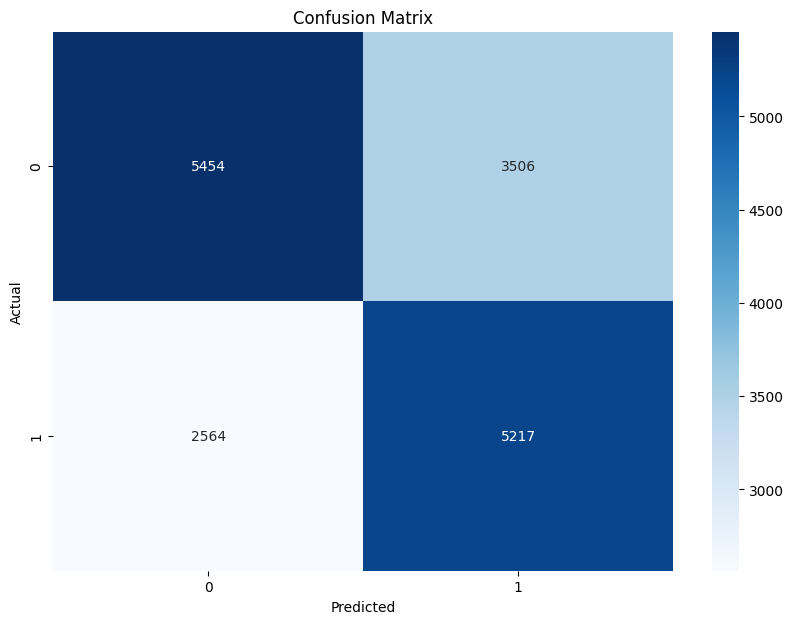

In [57]:
# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

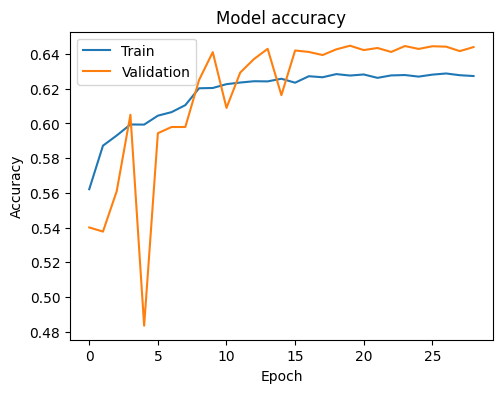

In [44]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

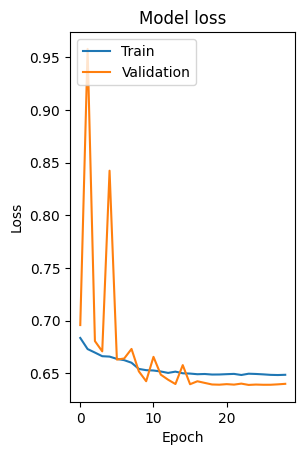

In [45]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [31]:
model.save('resnet_model_final.h5')

/Users/arnodebelle/.pyenv/versions/3.10.6/envs/chest_predictor/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
model.save('resnet_model.keras')